In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

# 1. DB 연결
db_uri = "postgresql+psycopg2://xodh3@localhost:5432/economy_db"
engine = create_engine(db_uri)

In [24]:
# ---------------------------------------------------------
# 2. 데이터 불러오기 함수 (안전하게 컬럼 이름 통일)
# ---------------------------------------------------------
def get_data(symbol, new_col_name):
    query = f"""
    SELECT date_time, value
    FROM macro_time_series
    WHERE indicator_symbol = '{symbol}'
    ORDER BY date_time ASC;
    """
    df = pd.read_sql(query, engine)
    # 컬럼 이름 강제 변경 (date_time -> trade_date, value -> 우리가 원하는 이름)
    df = df.rename(columns={'date_time': 'trade_date', 'value': new_col_name})
    # 날짜 변환 및 월말(Month End) 기준 통일
    df['trade_date'] = pd.to_datetime(df['trade_date'], utc=True)
    df = df.set_index('trade_date').resample('M').last()
    return df


In [25]:
# ---------------------------------------------------------
# 3. 핵심 재료 소환!
# ---------------------------------------------------------
print("데이터 불러오는 중...", end=" ")

# (1) 실업률
df_unrate = get_data('UNRATE', 'unrate')

# (2) 10년물 국채 금리
df_10y = get_data('UNITED_STATES_GOVERNMENT_BOND_10Y', 'us10y')

# (3) 기준금리 (2년물 대신 사용)
df_fed = get_data('FEDFUNDS', 'fed_rate')

# (4) QQQ 주가 (이건 테이블이 달라서 따로 불러옵니다)
query_qqq = """
SELECT trade_date::text AS trade_date, close_price
FROM market_price_daily
WHERE symbol = 'QQQ'
ORDER BY trade_date ASC;
"""
df_qqq = pd.read_sql(query_qqq, engine)
df_qqq['trade_date'] = pd.to_datetime(df_qqq['trade_date'], utc=True)
df_qqq = df_qqq.set_index('trade_date').resample('ME').last()

print("완료! ✅")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

# 1. DB 연결
db_uri = "postgresql+psycopg2://xodh3@localhost:5432/economy_db"
engine = create_engine(db_uri)

# ---------------------------------------------------------
# 2. 데이터 불러오기 함수 (안전하게 컬럼 이름 통일)
# ---------------------------------------------------------
def get_data(symbol, new_col_name):
    query = f"""
    SELECT date_time, value
    FROM macro_time_series
    WHERE indicator_symbol = '{symbol}'
    ORDER BY date_time ASC;
    """
    df = pd.read_sql(query, engine)
    # 컬럼 이름 강제 변경 (date_time -> trade_date, value -> 우리가 원하는 이름)
    df = df.rename(columns={'date_time': 'trade_date', 'value': new_col_name})
    # 날짜 변환 및 월말(Month End) 기준 통일
    df['trade_date'] = pd.to_datetime(df['trade_date'], utc=True)
    df = df.set_index('trade_date').resample('ME').last()
    return df

# ---------------------------------------------------------
# 3. 핵심 재료 소환!
# ---------------------------------------------------------
print("데이터 불러오는 중...", end=" ")

# (1) 실업률
df_unrate = get_data('UNRATE', 'unrate')

# (2) 10년물 국채 금리
df_10y = get_data('UNITED_STATES_GOVERNMENT_BOND_10Y', 'us10y')

# (3) 기준금리 (2년물 대신 사용)
df_fed = get_data('FEDFUNDS', 'fed_rate')

# (4) QQQ 주가 (이건 테이블이 달라서 따로 불러옵니다)
query_qqq = """
SELECT trade_date::text AS trade_date, close_price
FROM market_price_daily
WHERE symbol = 'QQQ'
ORDER BY trade_date ASC;
"""
df_qqq = pd.read_sql(query_qqq, engine)
df_qqq['trade_date'] = pd.to_datetime(df_qqq['trade_date'], utc=True)
df_qqq = df_qqq.set_index('trade_date').resample('ME').last()

print("완료! ✅")

# ---------------------------------------------------------
# 4. 하나로 합치기 (All in One)
# ---------------------------------------------------------
# merge를 연쇄적으로 사용해서 하나로 묶습니다.
df_signal = df_qqq.join([df_unrate, df_10y, df_fed], how='inner')

# 5. [파생 지표] 장단기 금리차 계산 (Spread)
df_signal['spread'] = df_signal['us10y'] - df_signal['fed_rate']

# 결과 확인
print(f"📊 통합 데이터셋 준비 완료 (데이터 개수: {len(df_signal)}개)")
print(df_signal.tail())


데이터 불러오는 중... 완료! ✅
데이터 불러오는 중... 

/var/folders/px/mxxc21bs63gcw44m35sp_51r0000gn/T/ipykernel_62011/3987181150.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.set_index('trade_date').resample('M').last()
/var/folders/px/mxxc21bs63gcw44m35sp_51r0000gn/T/ipykernel_62011/3987181150.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.set_index('trade_date').resample('M').last()
/var/folders/px/mxxc21bs63gcw44m35sp_51r0000gn/T/ipykernel_62011/3987181150.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.set_index('trade_date').resample('M').last()


완료! ✅
📊 통합 데이터셋 준비 완료 (데이터 개수: 240개)
                           close_price  unrate  us10y  fed_rate  spread
trade_date                                                             
2025-04-30 00:00:00+00:00   474.941940       4      4         4       0
2025-05-31 00:00:00+00:00   518.533473       4      4         4       0
2025-06-30 00:00:00+00:00   551.640000       4      4         4       0
2025-07-31 00:00:00+00:00   565.010000       4      4         4       0
2025-08-31 00:00:00+00:00   570.400000       4      4         4       0


🚦 작전명: "샴의 법칙(Sahm Rule) + 역전 현상" 퓨전

월가에서 가장 신뢰하는 두 가지 위기 신호를 합칠 겁니다.

선행 지표 (예언자): 장단기 금리차 (spread)

"앞으로 1년 뒤에 비가 올 거야." (미래 예측)

조건: 금리차가 **0 미만(음수)**이면 위험!

동행 지표 (확인사살): 실업률 급등 (Sahm Rule 응용)

"지금 밖에 비 오고 있어!" (현재 상황 확인)

조건: 실업률이 최근 1년 최저치보다 0.5%p 이상 튀어 오르면 이미 침체 시작!

⌨️ [Step 1] 알고리즘 구현 (복합 신호 만들기)

아래 코드를 복사해서 실행해 주세요. 컴퓨터에게 **"위기 판독기"**를 심어주는 과정입니다.

In [26]:
# 1. 샴의 법칙(Sahm Rule) 지표 만들기
# "최근 12개월 중 실업률이 가장 낮았을 때보다, 지금 0.5%p 이상 올랐나?"
# rolling(12).min(): 과거 12개월 중 최저 실업률
df_signal['unrate_min_12m'] = df_signal['unrate'].rolling(window=12).min()
df_signal['sahm_signal'] = (df_signal['unrate'] >= df_signal['unrate_min_12m'] + 0.5)

# 2. 장단기 금리차 역전 신호 만들기
# "금리차가 마이너스인가?"
df_signal['yield_signal'] = (df_signal['spread'] < 0)

# 3. 🚨 [최종 보스] 복합 위기 신호 (Composite Signal)
# 두 신호 중 하나라도 켜지면 '위험(True)', 아니면 '안전(False)'
# ( | 기호는 OR 연산자입니다 )
df_signal['crisis_alert'] = df_signal['sahm_signal'] | df_signal['yield_signal']

# 결과 확인: 위기 신호가 켜진(True) 달이 언제인지 봅니다.
print("🚨 위기 경보가 켜진 달 (최근 10개):")
print(df_signal[df_signal['crisis_alert'] == True][['close_price', 'spread', 'unrate', 'crisis_alert']].tail(10))

🚨 위기 경보가 켜진 달 (최근 10개):
                           close_price  spread  unrate  crisis_alert
trade_date                                                          
2023-12-31 00:00:00+00:00   406.062172      -1       4          True
2024-01-31 00:00:00+00:00   413.449267      -1       4          True
2024-02-29 00:00:00+00:00   435.293255      -1       4          True
2024-03-31 00:00:00+00:00   440.838047      -1       4          True
2024-06-30 00:00:00+00:00   476.451573      -1       4          True
2024-07-31 00:00:00+00:00   468.456184      -1       4          True
2024-08-31 00:00:00+00:00   473.627331      -1       4          True
2024-09-30 00:00:00+00:00   486.041970      -1       4          True
2024-10-31 00:00:00+00:00   481.839505      -1       4          True
2024-11-30 00:00:00+00:00   507.621927      -1       4          True


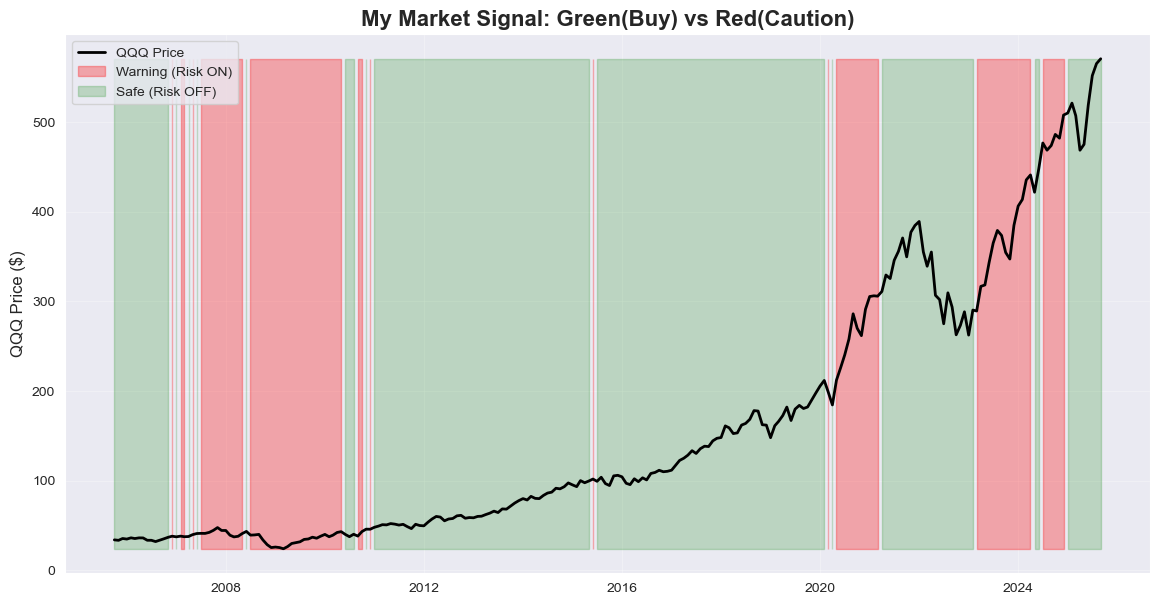

In [27]:
import matplotlib.pyplot as plt

# 1. 그래프 준비
fig, ax = plt.subplots(figsize=(14, 7))

# 2. QQQ 주가 그리기 (검은 실선)
ax.plot(df_signal.index, df_signal['close_price'], color='black', linewidth=2, label='QQQ Price')

# 3. 🚦 신호등 켜기 (배경색 칠하기)
# y축의 범위를 구해서 꽉 차게 칠합니다.
y_min, y_max = df_signal['close_price'].min(), df_signal['close_price'].max()

# (1) 위험 구간 (Red Zone): crisis_alert가 True인 곳
ax.fill_between(df_signal.index, y_min, y_max,
                where=df_signal['crisis_alert'],
                color='red', alpha=0.3, label='Warning (Risk ON)')

# (2) 안전 구간 (Green Zone): crisis_alert가 False인 곳
# ~ 기호는 '반대(NOT)'를 의미합니다.
ax.fill_between(df_signal.index, y_min, y_max,
                where=~df_signal['crisis_alert'],
                color='green', alpha=0.2, label='Safe (Risk OFF)')

# 4. 꾸미기
ax.set_title("My Market Signal: Green(Buy) vs Red(Caution)", fontsize=16, fontweight='bold')
ax.set_ylabel("QQQ Price ($)", fontsize=12)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.show()

/opt/anaconda3/envs/mymy/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51316 (\N{HANGUL SYLLABLE JON}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/mymy/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48260 (\N{HANGUL SYLLABLE BEO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/mymy/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/mymy/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49437 (\N{HANGUL SYLLABLE SEOG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/mymy/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50504 (\N{HANGUL SYLLABLE AN}) missing from font(s) Arial.
  fig

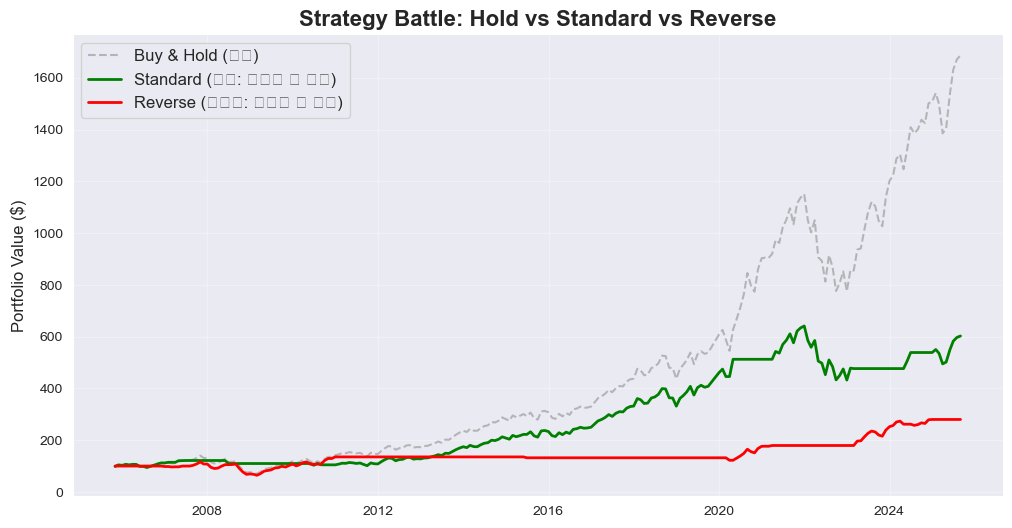

🏁 최종 성적표 (100달러 투자 시):
1. 존버 (Buy & Hold): $1686.77
2. 정석 (안전 제일): $602.44
3. 역발상 (야수의 심장): $279.99


In [28]:
import matplotlib.pyplot as plt

# 1. 기초 수익률 계산 (QQQ가 한 달에 얼마나 변했나?)
df_signal['qqq_return'] = df_signal['close_price'].pct_change()

# ---------------------------------------------------------
# 2. 3가지 전략 세팅 (포지션: 1=보유, 0=현금보유)
# ---------------------------------------------------------

# (1) 존버 전략: 무조건 보유 (1)
df_signal['pos_hold'] = 1

# (2) 정석 신호: 위기(True)면 도망(0), 안전(False)이면 보유(1)
# ~ 연산자는 True/False를 뒤집습니다. (위기가 아닐 때 산다)
df_signal['pos_signal'] = (~df_signal['crisis_alert']).astype(int)

# (3) 역발상(청개구리): 위기(True)일 때만 사고(1), 안전하면 쉰다(0)
# 님의 가설: "위기 때 돈이 풀려서 오른다!"
df_signal['pos_reverse'] = df_signal['crisis_alert'].astype(int)

# ---------------------------------------------------------
# 3. 전략별 수익률 계산 (핵심: 어제 신호 보고 오늘 매매)
# ---------------------------------------------------------
# shift(1)을 해야 '전달 신호'를 보고 '이번 달' 수익을 가져갑니다.
df_signal['strat_hold'] = df_signal['pos_hold'].shift(1) * df_signal['qqq_return']
df_signal['strat_signal'] = df_signal['pos_signal'].shift(1) * df_signal['qqq_return']
df_signal['strat_reverse'] = df_signal['pos_reverse'].shift(1) * df_signal['qqq_return']

# 4. 누적 수익률 계산 (복리)
# (1 + 수익률)을 계속 곱해나갑니다. 초기자금 100달러 가정.
df_signal['cum_hold'] = (1 + df_signal['strat_hold']).cumprod() * 100
df_signal['cum_signal'] = (1 + df_signal['strat_signal']).cumprod() * 100
df_signal['cum_reverse'] = (1 + df_signal['strat_reverse']).cumprod() * 100

# ---------------------------------------------------------
# 5. 결과 그래프 그리기
# ---------------------------------------------------------
fig, ax = plt.subplots(figsize=(12, 6))

# 세 전략 그리기
ax.plot(df_signal.index, df_signal['cum_hold'], label='Buy & Hold (존버)', color='gray', alpha=0.5, linestyle='--')
ax.plot(df_signal.index, df_signal['cum_signal'], label='Standard (정석: 안전할 때 매수)', color='green', linewidth=2)
ax.plot(df_signal.index, df_signal['cum_reverse'], label='Reverse (역발상: 위험할 때 매수)', color='red', linewidth=2)

ax.set_title("Strategy Battle: Hold vs Standard vs Reverse", fontsize=16, fontweight='bold')
ax.set_ylabel("Portfolio Value ($)", fontsize=12)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

plt.show()

# 최종 수익률 출력
print("🏁 최종 성적표 (100달러 투자 시):")
print(f"1. 존버 (Buy & Hold): ${df_signal['cum_hold'].iloc[-1]:.2f}")
print(f"2. 정석 (안전 제일): ${df_signal['cum_signal'].iloc[-1]:.2f}")
print(f"3. 역발상 (야수의 심장): ${df_signal['cum_reverse'].iloc[-1]:.2f}")

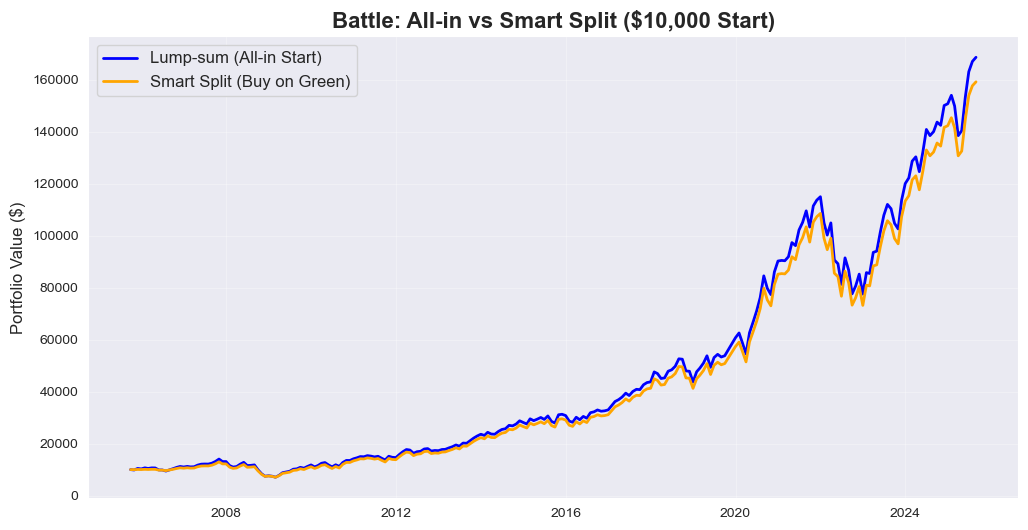

🏁 최종 성적표 (초기자금 $10,000):
1. 한 방 매수 (Lump-sum): $168,676.90 (수익률: 1586.8%)
2. 분할 매수 (Smart Split): $159,227.61 (수익률: 1492.3%)
👉 차액: $9,449.29


In [29]:
import matplotlib.pyplot as plt

# 1. 초기 설정
initial_capital = 10000  # 1만불
installment_amount = 500 # 한 번에 500불씩 분할 매수 (총 20회 분량)

# ---------------------------------------------------------
# 전략 A: 남자답게 한 방 (Lump-sum Buy & Hold)
# ---------------------------------------------------------
# 첫 날 가격으로 주식을 몽땅 삽니다.
first_price = df_signal['close_price'].iloc[0]
shares_lump = initial_capital / first_price

# 자산 가치 변화 = 주식 수 * 현재 가격
df_signal['value_lump'] = shares_lump * df_signal['close_price']

# ---------------------------------------------------------
# 전략 B: 신중한 스나이퍼 (Smart Split Buying)
# ---------------------------------------------------------
# 반복문을 돌면서 시뮬레이션해야 합니다.
cash = initial_capital
shares = 0
value_history = []

for i, row in df_signal.iterrows():
    price = row['close_price']
    is_crisis = row['crisis_alert'] # True(위험), False(안전)

    # 1. 매수 로직: 돈이 있고 + 안전(Green)할 때만 산다!
    if cash > 0 and not is_crisis:
        # 남은 돈이 할부금보다 적으면 털어 넣기
        buy_amt = min(cash, installment_amount)

        # 주식 매수
        new_shares = buy_amt / price
        shares += new_shares
        cash -= buy_amt

    # 2. 현재 내 자산 가치 계산 (주식 평가액 + 남은 현금)
    current_value = (shares * price) + cash
    value_history.append(current_value)

# 결과 저장
df_signal['value_split'] = value_history

# ---------------------------------------------------------
# 3. 결과 그래프 그리기
# ---------------------------------------------------------
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df_signal.index, df_signal['value_lump'], label='Lump-sum (All-in Start)', color='blue', linewidth=2)
ax.plot(df_signal.index, df_signal['value_split'], label='Smart Split (Buy on Green)', color='orange', linewidth=2)

ax.set_title(f"Battle: All-in vs Smart Split ($10,000 Start)", fontsize=16, fontweight='bold')
ax.set_ylabel("Portfolio Value ($)", fontsize=12)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

plt.show()

# 최종 성적표
final_lump = df_signal['value_lump'].iloc[-1]
final_split = df_signal['value_split'].iloc[-1]
roi_lump = (final_lump - initial_capital) / initial_capital * 100
roi_split = (final_split - initial_capital) / initial_capital * 100

print("🏁 최종 성적표 (초기자금 $10,000):")
print(f"1. 한 방 매수 (Lump-sum): ${final_lump:,.2f} (수익률: {roi_lump:.1f}%)")
print(f"2. 분할 매수 (Smart Split): ${final_split:,.2f} (수익률: {roi_split:.1f}%)")
print(f"👉 차액: ${final_lump - final_split:,.2f}")

3대장 소환 중... 완료! ✅
                                  QQQ         SPY         DIA  spread
trade_date                                                           
2025-04-30 00:00:00+00:00  474.941940  552.901506  404.478537       0
2025-05-31 00:00:00+00:00  518.533473  587.648535  421.230234       0
2025-06-30 00:00:00+00:00  551.640000  617.850000  440.210265       0
2025-07-31 00:00:00+00:00  565.010000  632.080000  441.069369       0
2025-08-31 00:00:00+00:00  570.400000  645.050000  456.090000       0


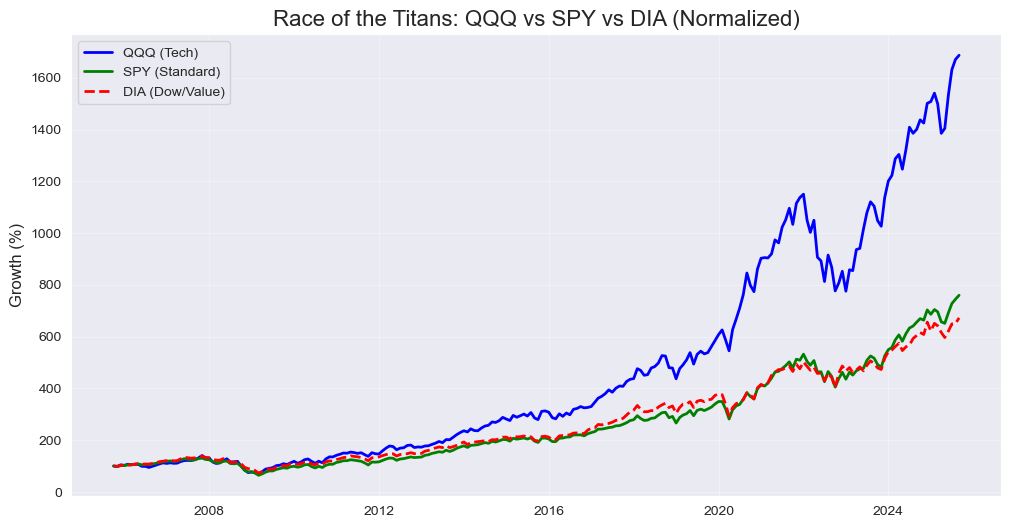

📊 장단기 금리차(Spread)와의 상관계수:
QQQ      -0.523188
SPY      -0.542081
DIA      -0.544388
spread    1.000000
Name: spread, dtype: float64


In [30]:
# 1. 3대장 데이터 불러오기 함수
def get_price_data(symbol):
    query = f"""
    SELECT trade_date::text AS trade_date, close_price
    FROM market_price_daily
    WHERE symbol = '{symbol}'
    ORDER BY trade_date ASC;
    """
    df = pd.read_sql(query, engine)
    df['trade_date'] = pd.to_datetime(df['trade_date'], utc=True)
    # 이름을 close_price 대신 심볼 이름(QQQ, SPY...)으로 변경
    df = df.set_index('trade_date').resample('ME').last()
    df = df.rename(columns={'close_price': symbol})
    return df

# 2. 데이터 수집 및 합치기
print("3대장 소환 중...", end=" ")
df_qqq = get_price_data('QQQ')
df_spy = get_price_data('SPY')
df_dia = get_price_data('DIA') # 다우존스 ETF

# 하나의 테이블로 합체 (기존 df_signal에 붙이기보다는 새로 깔끔하게)
df_market = df_qqq.join([df_spy, df_dia], how='inner')

# 3. 상관관계 분석 (누가 금리차와 제일 친한가?)
# 아까 만든 금리차(spread) 데이터를 가져와서 붙입니다.
df_market = df_market.join(df_signal['spread'], how='inner')

print("완료! ✅")
print(df_market.tail())

# ---------------------------------------------------------
# 4. 3대장 비교 그래프 그리기 (정규화)
# ---------------------------------------------------------
# 가격대가 다르니(QQQ는 500불, DIA는 400불...),
# 시작점을 100으로 맞춰서(정규화) 상승률을 비교합니다.
df_norm = (df_market[['QQQ', 'SPY', 'DIA']] / df_market[['QQQ', 'SPY', 'DIA']].iloc[0]) * 100

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df_norm.index, df_norm['QQQ'], label='QQQ (Tech)', color='blue', linewidth=2)
ax.plot(df_norm.index, df_norm['SPY'], label='SPY (Standard)', color='green', linewidth=2)
ax.plot(df_norm.index, df_norm['DIA'], label='DIA (Dow/Value)', color='red', linewidth=2, linestyle='--')

ax.set_title("Race of the Titans: QQQ vs SPY vs DIA (Normalized)", fontsize=16)
ax.set_ylabel("Growth (%)", fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()

# 5. 상관계수 확인 (금리차와의 관계)
print("📊 장단기 금리차(Spread)와의 상관계수:")
print(df_market.corr()['spread'])

In [31]:
# ---------------------------------------------------------
# 전략 B 수정: 신중한 스나이퍼 + 현금 이자 수익 (Cash Interest)
# ---------------------------------------------------------
cash = initial_capital
shares = 0
value_history = []

for i, row in df_signal.iterrows():
    price = row['close_price']
    is_crisis = row['crisis_alert']
    # 기준금리 데이터 (연이율 % -> 월이율 변환)
    # 데이터에 fed_rate가 없으면 0으로 처리 (에러 방지)
    fed_rate = row['fed_rate'] if 'fed_rate' in row else 0
    monthly_interest = fed_rate / 100 / 12

    # 1. 💰 [핵심 추가] 지난달 남은 현금에 이자가 붙습니다!
    if cash > 0:
        cash = cash * (1 + monthly_interest)

    # 2. 매수 로직 (안전할 때만)
    if cash > 0 and not is_crisis:
        buy_amt = min(cash, installment_amount)
        new_shares = buy_amt / price
        shares += new_shares
        cash -= buy_amt

    current_value = (shares * price) + cash
    value_history.append(current_value)

df_signal['value_split_interest'] = value_history

# 결과 비교 출력
final_split_interest = df_signal['value_split_interest'].iloc[-1]
roi_interest = (final_split_interest - initial_capital) / initial_capital * 100

print("🏁 현금 이자까지 포함한 재대결 결과:")
print(f"1. 한 방 매수 (Lump-sum): ${final_lump:,.2f}")
print(f"2. 분할 매수 + 이자 수익: ${final_split_interest:,.2f} (수익률: {roi_interest:.1f}%)")
print(f"👉 차이: ${final_lump - final_split_interest:,.2f} (격차가 줄었나요?)")

🏁 현금 이자까지 포함한 재대결 결과:
1. 한 방 매수 (Lump-sum): $168,676.90
2. 분할 매수 + 이자 수익: $166,767.95 (수익률: 1567.7%)
👉 차이: $1,908.95 (격차가 줄었나요?)


🚀 데이터 수집 시작... 완료! ✅
                                  QQQ         SPY         DIA  Fed_Rate  \
trade_date                                                                
2025-03-31 00:00:00+00:00  468.399215  557.737176  417.746324         4   
2025-04-30 00:00:00+00:00  474.941940  552.901506  404.478537         4   
2025-05-31 00:00:00+00:00  518.533473  587.648535  421.230234         4   
2025-06-30 00:00:00+00:00  551.640000  617.850000  440.210265         4   
2025-07-31 00:00:00+00:00  565.010000  632.080000  441.069369         4   

                           US10Y  Unrate  CPI     M2  Spread  
trade_date                                                    
2025-03-31 00:00:00+00:00      4       4  320  21657       0  
2025-04-30 00:00:00+00:00      4       4  320  21862       0  
2025-05-31 00:00:00+00:00      4       4  321  21884       0  
2025-06-30 00:00:00+00:00      4       4  322  22021       0  
2025-07-31 00:00:00+00:00      4       4  322  22115       0  


/var/folders/px/mxxc21bs63gcw44m35sp_51r0000gn/T/ipykernel_62011/2283436649.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
/var/folders/px/mxxc21bs63gcw44m35sp_51r0000gn/T/ipykernel_62011/2283436649.py:38: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.set_index('trade_date').resample('M').last()
/var/folders/px/mxxc21bs63gcw44m35sp_51r0000gn/T/ipykernel_62011/2283436649.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
/var/folders/px/mxxc21bs63gcw44m35sp_51r0000gn/T/ipykernel_62011/2283436649.py:38: FutureWarning: 'M' is deprecated and will be rem

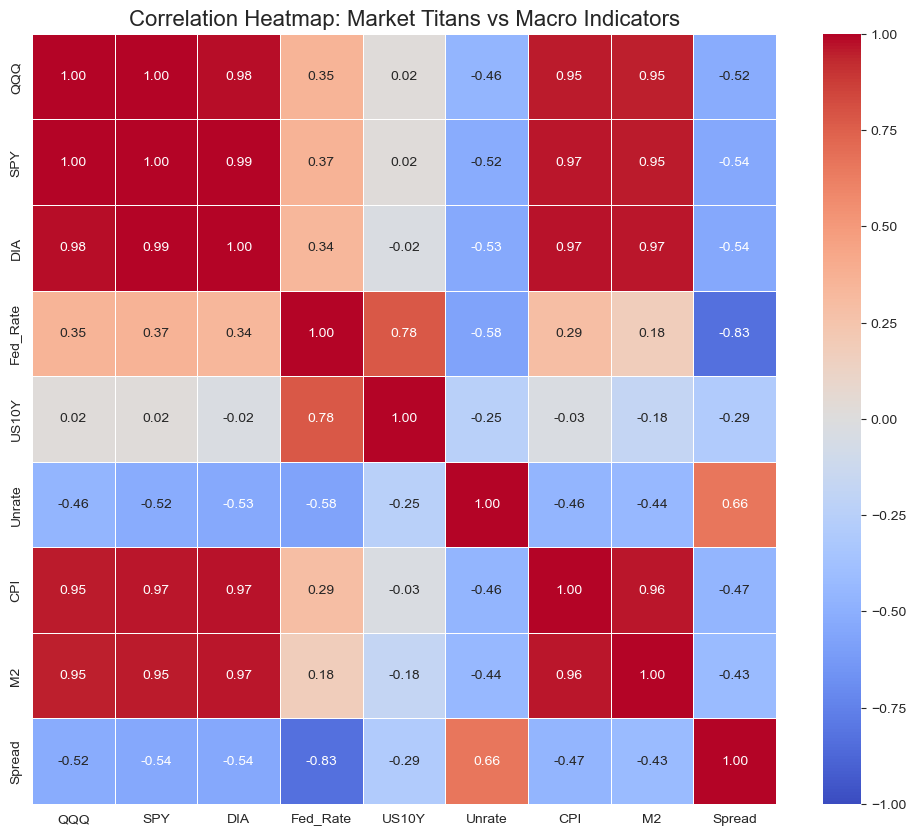

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1. 데이터 불러오기 함수 (수정됨: 날짜 컬럼 자동 인식)
# ---------------------------------------------------------
def get_data(symbol, col_name, is_market=False):
    # 1. 테이블과 날짜 컬럼 이름 정하기 (여기가 핵심!)
    if is_market:
        table = "market_price_daily"
        col_target = "close_price"
        col_date = "trade_date"  # 주식 테이블은 trade_date
    else:
        table = "macro_time_series"
        col_target = "value"
        col_date = "date_time"   # 경제 테이블은 date_time

    # 2. 쿼리 작성 (f-string으로 이름 교체)
    query = f"""
    SELECT {col_date}, {col_target}
    FROM {table}
    WHERE {('symbol' if is_market else 'indicator_symbol')} = '{symbol}'
    ORDER BY {col_date} ASC;
    """

    # 3. 데이터 가져오기 (raw_connection 사용)
    conn = engine.raw_connection()
    try:
        df = pd.read_sql(query, conn)
    finally:
        conn.close()

    # 4. 전처리 (이름 통일)
    # 가져온 날짜 컬럼(trade_date든 date_time이든)을 'trade_date'로 통일
    df = df.rename(columns={col_date: 'trade_date', col_target: col_name})
    df['trade_date'] = pd.to_datetime(df['trade_date'], utc=True)
    df = df.set_index('trade_date').resample('M').last()

    return df

# ---------------------------------------------------------
# 2. 8명의 선수 소환! (이제 에러 안 남)
# ---------------------------------------------------------
print("🚀 데이터 수집 시작...", end=" ")

# (1) 주식 3대장 (trade_date 사용)
df_qqq = get_data('QQQ', 'QQQ', is_market=True)
df_spy = get_data('SPY', 'SPY', is_market=True)
df_dia = get_data('DIA', 'DIA', is_market=True)

# (2) 경제 지표 5대장 (date_time 사용)
# 🚨 주의: 심볼 이름은 아까 확인한 정확한 이름으로 넣었습니다!
df_fed = get_data('FEDFUNDS', 'Fed_Rate')
df_10y = get_data('UNITED_STATES_GOVERNMENT_BOND_10Y', 'US10Y')
df_unrate = get_data('UNRATE', 'Unrate')
df_cpi = get_data('CPIAUCSL', 'CPI')
df_m2 = get_data('UNITED_STATES_MONEY_SUPPLY_M2', 'M2')

# 3. 하나로 합치기
dfs = [df_qqq, df_spy, df_dia, df_fed, df_10y, df_unrate, df_cpi, df_m2]
df_titan = pd.concat(dfs, axis=1, join='inner')

# 4. 파생 지표 (Spread)
df_titan['Spread'] = df_titan['US10Y'] - df_titan['Fed_Rate']

# 5. 상관관계 계산
corr_matrix = df_titan.corr()

print("완료! ✅")
print(df_titan.tail())

# ---------------------------------------------------------
# 3. 히트맵 그리기
# ---------------------------------------------------------
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title("Correlation Heatmap: Market Titans vs Macro Indicators", fontsize=16)
plt.show()

🦁 Loading Market Titans (QQQ, SPY, DIA)...

📂 Analyzing: 1_Employment ...


/var/folders/px/mxxc21bs63gcw44m35sp_51r0000gn/T/ipykernel_62011/3538935909.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
/var/folders/px/mxxc21bs63gcw44m35sp_51r0000gn/T/ipykernel_62011/3538935909.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
/var/folders/px/mxxc21bs63gcw44m35sp_51r0000gn/T/ipykernel_62011/3538935909.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
/var/folders/px/mxxc21bs63gcw44m35sp_51r0000gn/T/ipy

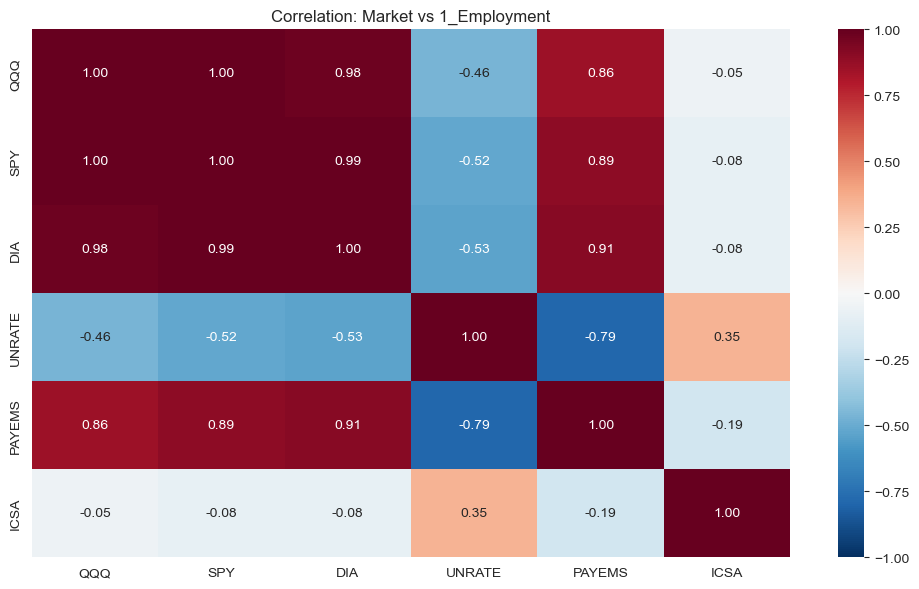

✅ 1_Employment Done!

📂 Analyzing: 2_Inflation ...


/var/folders/px/mxxc21bs63gcw44m35sp_51r0000gn/T/ipykernel_62011/3538935909.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


  ⚠️ Data Not Found: PPIACO


/var/folders/px/mxxc21bs63gcw44m35sp_51r0000gn/T/ipykernel_62011/3538935909.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
/var/folders/px/mxxc21bs63gcw44m35sp_51r0000gn/T/ipykernel_62011/3538935909.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


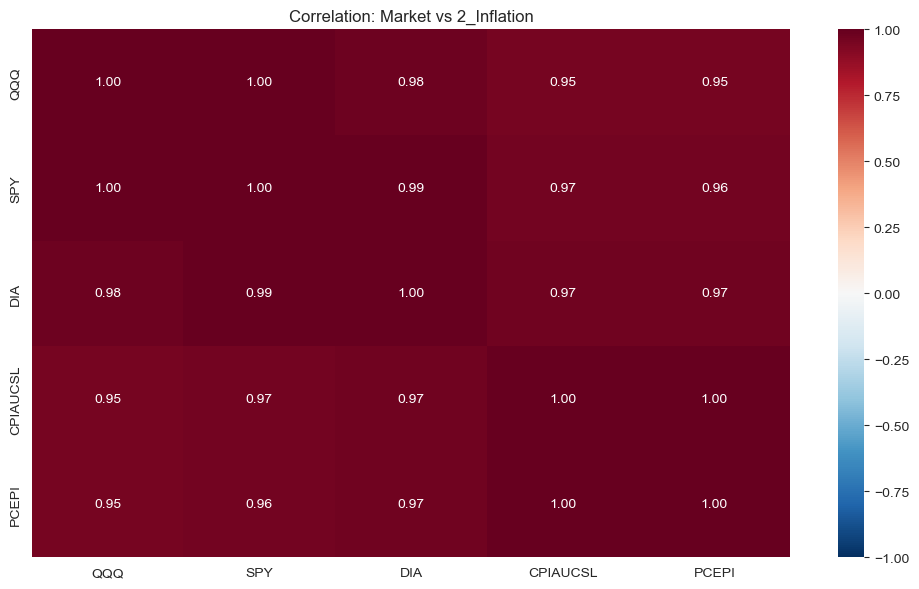

✅ 2_Inflation Done!

📂 Analyzing: 3_Housing_Sentiment ...


/var/folders/px/mxxc21bs63gcw44m35sp_51r0000gn/T/ipykernel_62011/3538935909.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
/var/folders/px/mxxc21bs63gcw44m35sp_51r0000gn/T/ipykernel_62011/3538935909.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
/var/folders/px/mxxc21bs63gcw44m35sp_51r0000gn/T/ipykernel_62011/3538935909.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


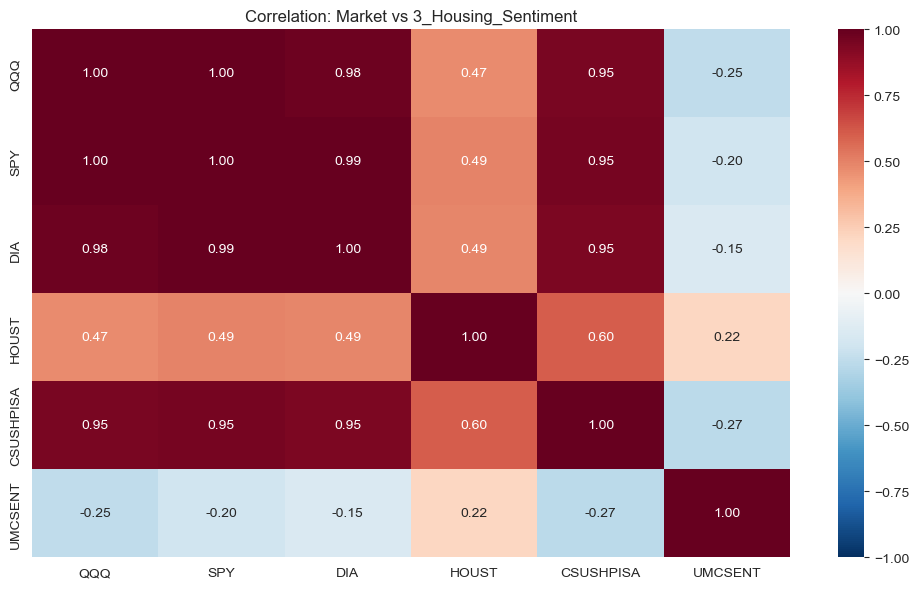

✅ 3_Housing_Sentiment Done!

📂 Analyzing: 4_Money_Production ...


/var/folders/px/mxxc21bs63gcw44m35sp_51r0000gn/T/ipykernel_62011/3538935909.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
/var/folders/px/mxxc21bs63gcw44m35sp_51r0000gn/T/ipykernel_62011/3538935909.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
/var/folders/px/mxxc21bs63gcw44m35sp_51r0000gn/T/ipykernel_62011/3538935909.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
/var/folders/px/mxxc21bs63gcw44m35sp_51r0000gn/T/ipy

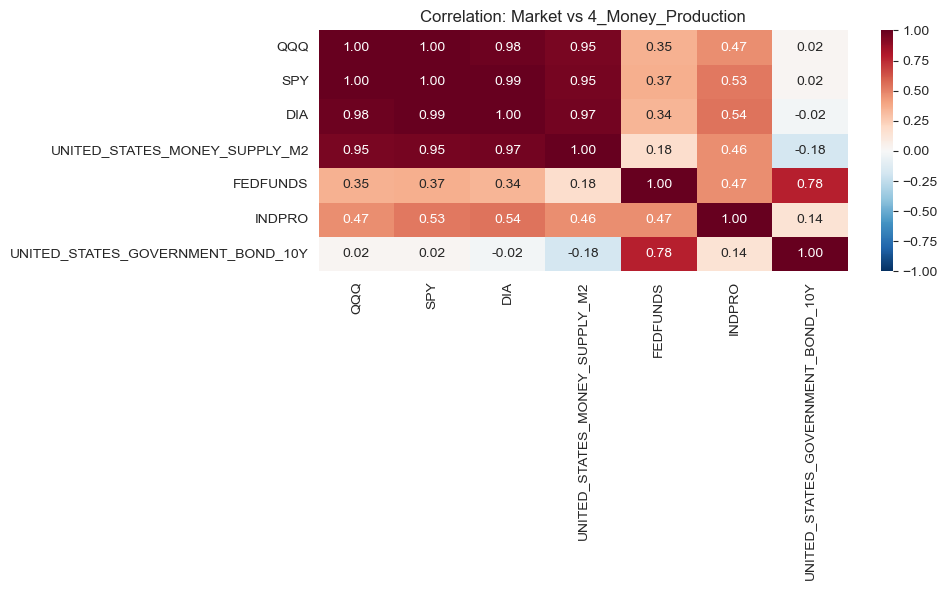

✅ 4_Money_Production Done!

🏁 All Analysis Finished.


In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1. 카테고리 이름 영어로 변경 (한글 폰트 깨짐 방지)
# ---------------------------------------------------------
CATEGORY_MAP = {
    "1_Employment": ['UNRATE', 'PAYEMS', 'ICSA'],
    "2_Inflation": ['CPIAUCSL', 'PCEPI', 'PPIACO'],
    "3_Housing_Sentiment": ['HOUST', 'CSUSHPISA', 'UMCSENT'],
    "4_Money_Production": ['M2', 'FEDFUNDS', 'INDPRO', 'US10Y']
}

# ---------------------------------------------------------
# 2. 데이터 불러오기 함수
# ---------------------------------------------------------
def get_data_safe(symbol, is_market=False):
    if is_market:
        table, col_date, col_target = "market_price_daily", "trade_date", "close_price"
    else:
        table, col_date, col_target = "macro_time_series", "date_time", "value"

    query = f"SELECT {col_date}, {col_target} FROM {table} WHERE {('symbol' if is_market else 'indicator_symbol')} = '{symbol}' ORDER BY {col_date} ASC"

    conn = engine.raw_connection()
    try:
        df = pd.read_sql(query, conn)
    except:
        return pd.DataFrame()
    finally:
        conn.close()

    if df.empty: return df

    df = df.rename(columns={col_date: 'trade_date', col_target: symbol})
    df['trade_date'] = pd.to_datetime(df['trade_date'], utc=True)
    df = df.set_index('trade_date').resample('ME').last()
    return df

# ---------------------------------------------------------
# 3. 3대장 데이터 준비
# ---------------------------------------------------------
print("🦁 Loading Market Titans (QQQ, SPY, DIA)...")
df_qqq = get_data_safe('QQQ', is_market=True)
df_spy = get_data_safe('SPY', is_market=True)
df_dia = get_data_safe('DIA', is_market=True)
df_market = pd.concat([df_qqq, df_spy, df_dia], axis=1, join='inner')

# ---------------------------------------------------------
# 4. 카테고리별 자동 분석 루프
# ---------------------------------------------------------
for cat_name, indicators in CATEGORY_MAP.items():
    print(f"\n📂 Analyzing: {cat_name} ...")

    dfs = [df_market] # 3대장 먼저 넣고

    for ind in indicators:
        # 심볼 이름 자동 매핑 (DB에 저장된 진짜 이름으로 변환)
        real_symbol = ind
        if ind == 'M2': real_symbol = 'UNITED_STATES_MONEY_SUPPLY_M2'
        elif ind == 'US10Y': real_symbol = 'UNITED_STATES_GOVERNMENT_BOND_10Y'
        elif ind == 'PPIACO': real_symbol = 'PPIACO' # PPI가 없을 수도 있으니 체크

        df_temp = get_data_safe(real_symbol)

        if not df_temp.empty:
            dfs.append(df_temp)
        else:
            print(f"  ⚠️ Data Not Found: {real_symbol}")

    if len(dfs) > 1:
        # 합치기 & 히트맵 그리기
        df_cat = pd.concat(dfs, axis=1, join='inner')

        plt.figure(figsize=(10, 6))
        # cmap='RdBu_r' : 빨간색이 양의 상관관계(1), 파란색이 음의 상관관계(-1)
        sns.heatmap(df_cat.corr(), annot=True, fmt=".2f", cmap='RdBu_r', vmin=-1, vmax=1)
        plt.title(f"Correlation: Market vs {cat_name}")
        plt.tight_layout()
        plt.show()

        print(f"✅ {cat_name} Done!")
    else:
        print("  ❌ Not enough data.")

print("\n🏁 All Analysis Finished.")